In [1]:
import pandas as pd
import numpy as np
import h5py
from datetime import datetime, timedelta
import sys
### my analysis functions
from python_mobility import mobility_matrix_extract_modzcta as mm
from python_mobility import parameters as mp
from python_mobility import analysis as ma
### plot functions
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import TwoSlopeNorm, LogNorm
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

import geopandas as gpd
from shapely.geometry import Polygon
import matplotlib as mpl

import matplotlib.ticker as mticker
import matplotlib.dates as mdates

my package for mobility extraction has been imported!


In [3]:
# Assuming 'ma' and 'mp' are modules or objects you've defined elsewhere
n_categories = 7 #5
mobility_map_method = '1to1' #'1to1' '1tomore' 'loss_visitors' 
subfolder = 'mobility' if n_categories == 5 else 'mobility_cate7_{}'.format(mobility_map_method)

my_color = {2018:'green',2019:'blue',2020:'red', 2021:'orange',2022:'peru'}
start_date = pd.to_datetime('2020-02-03') ### moblity data start from monday to sunday 

dates_to_mark = [
    pd.to_datetime('2020-03-01'),
    pd.to_datetime('2020-03-16'),
    pd.to_datetime('2020-06-08'),
    pd.to_datetime('2020-09-30'),
    pd.to_datetime('2020-12-14')
]
subtitle_text = ['a','b','c','d','e','f']

In [4]:
Ms_combined = None
for y in [2020, 2021]:
    months = ['01', '02'] if y == 2021 else ['02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
    for month in months:
        Ms = ma.h5py_to_4d_array(f'../data/{subfolder}/M_raw_{y}{month}.h5')
        if Ms_combined is None:
            Ms_combined = Ms
        else:
            Ms_combined = np.concatenate((Ms_combined, Ms), axis=0)

num_days = Ms_combined.shape[0]
num_weeks = int(num_days / 7)

Ms_reshaped = Ms_combined.reshape(num_weeks, 7, n_categories, 177, 177)
Ms_weekly_sums = Ms_reshaped.sum(axis=1) # sum over days of the week, 
# final shape is (56, 7, 177, 177)
flow_out_wk = np.sum(Ms_weekly_sums, axis=2) # sum over destination modzcta
# final shape is (56, 7, 177)
flow_all_wk = np.sum(flow_out_wk, axis=2) # sum over origin modzcta 
# ## from feb 3 2020 (Monday) to feb 28 (Sunday) 2021 56 weeks

In [5]:
mp.cluster_name ### the names in the MS

{0: 'Grocery stores and pharmacies',
 1: 'General retail',
 2: 'Arts and entertainment venues',
 3: 'Restaurants and bars',
 4: 'Educational settings',
 5: 'Healthcare facilities',
 6: 'others'}

### Time series plot
#### **Weekly pattern**

292313.40527801105 107736.09896656053
699167.2710926059 169370.37428218557
734847.3734007224 146686.40356152362
1420096.9618651913 302162.67464047903
321656.0223916174 25653.564640140874
375771.4353525378 87169.33489360799


/var/folders/_0/2l3z2qss74scb88wvbv1szxr0000gn/T/ipykernel_63167/386849256.py:45: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


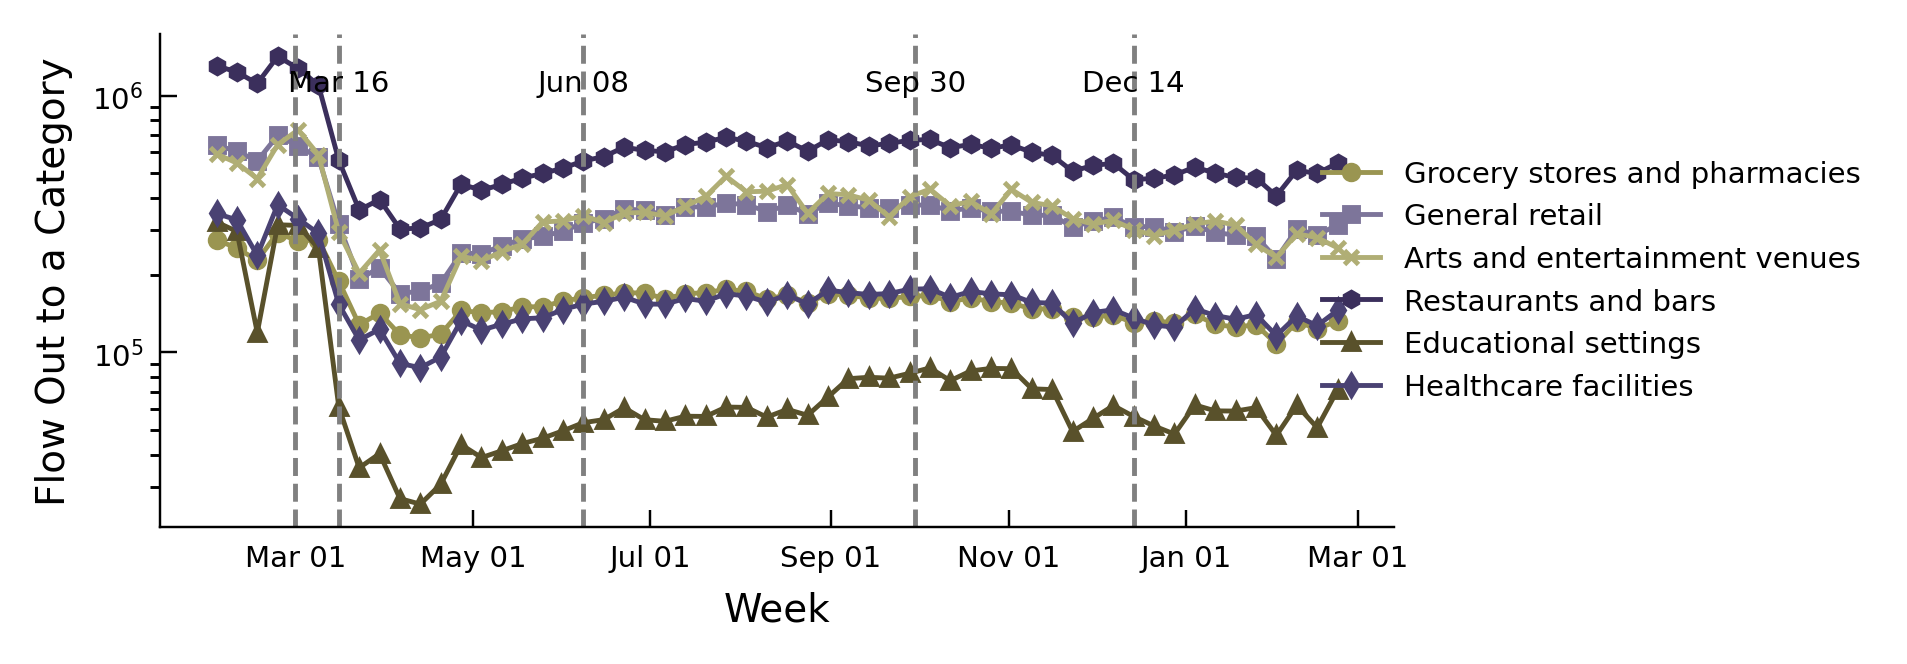

In [5]:
fig = plt.figure(figsize=(6, 2.), dpi=350,constrained_layout=True)  # Adjust figure size as needed
ax = fig.add_subplot(111)  # Single subplot for all categories

# Define different colors for each category
colors = ['#9A9551', '#7D759A', '#B0AE75', '#3B2F5C', '#59512B','#4A4273']
#3B2F5C - Deep Purple
#4A4273 - Slate Purple
#7D759A - Lavender Gray
#B0AE75 - Olive Green
#9A9551 - Mustard Olive
#59512B - Dark Olive
markers = ['o', 's', 'x', 'h', '^', 'd']
categories = range(6)  # only show 6 categories, not showing the 7th Others
start_date = '2020-02-03'  # start date

for c, color, marker in zip(categories, colors, markers):

    data = flow_all_wk[:, c]
    print(np.max(data),np.min(data))
    date_range = pd.date_range(start_date, periods=num_weeks, freq='W-MON') ### if not week use 'D'
    
    ax.plot(date_range, data, label=mp.cluster_name[c], color=color, marker=marker, lw=1, markersize=3)

# Add annotations and formatting
for date in dates_to_mark:
    ax.axvline(date, color='gray', linestyle='--', linewidth=1)
    if date != pd.to_datetime('2020-03-01'):
        ax.annotate(date.strftime('%b %d'), xy=(date, 0.9), xycoords=('data', 'axes fraction'),
                    ha='center', va='center', fontsize=6, rotation=0, backgroundcolor='None')

ax.set_yscale('log')
# ax.set_title('Weekly Total Flow Out by Place Category', fontsize=8, loc='center')
ax.set_xlabel('Week', fontsize=8)
ax.set_ylabel('Flow Out to a Category', fontsize=8)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.tick_params(axis='both', which='major', labelsize=6, width=0.5, direction='in')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)

# Display the legend
ax.legend(fontsize=6, loc='right', frameon=False, ncol=1, bbox_to_anchor=(1.4, 0.5)) #bbox_to_anchor=(0.5, -0.4)

plt.tight_layout()
# plt.savefig('../results/plots_maps/mobility_cate7_1to1.png',pad_inches=0.,bbox_inches='tight',transparent=True,dpi = 350) #bbox_inches='tight',
# plt.show()

#### **daily weekly flow out**

47863.22457829189 7660.75182342106
111821.7990749211 15046.484506173023
121662.79982125312 16040.444217353284
235887.99962830532 30066.437825895497
62286.819301681826 2985.9865390014993
66600.70466138874 9197.432991198442


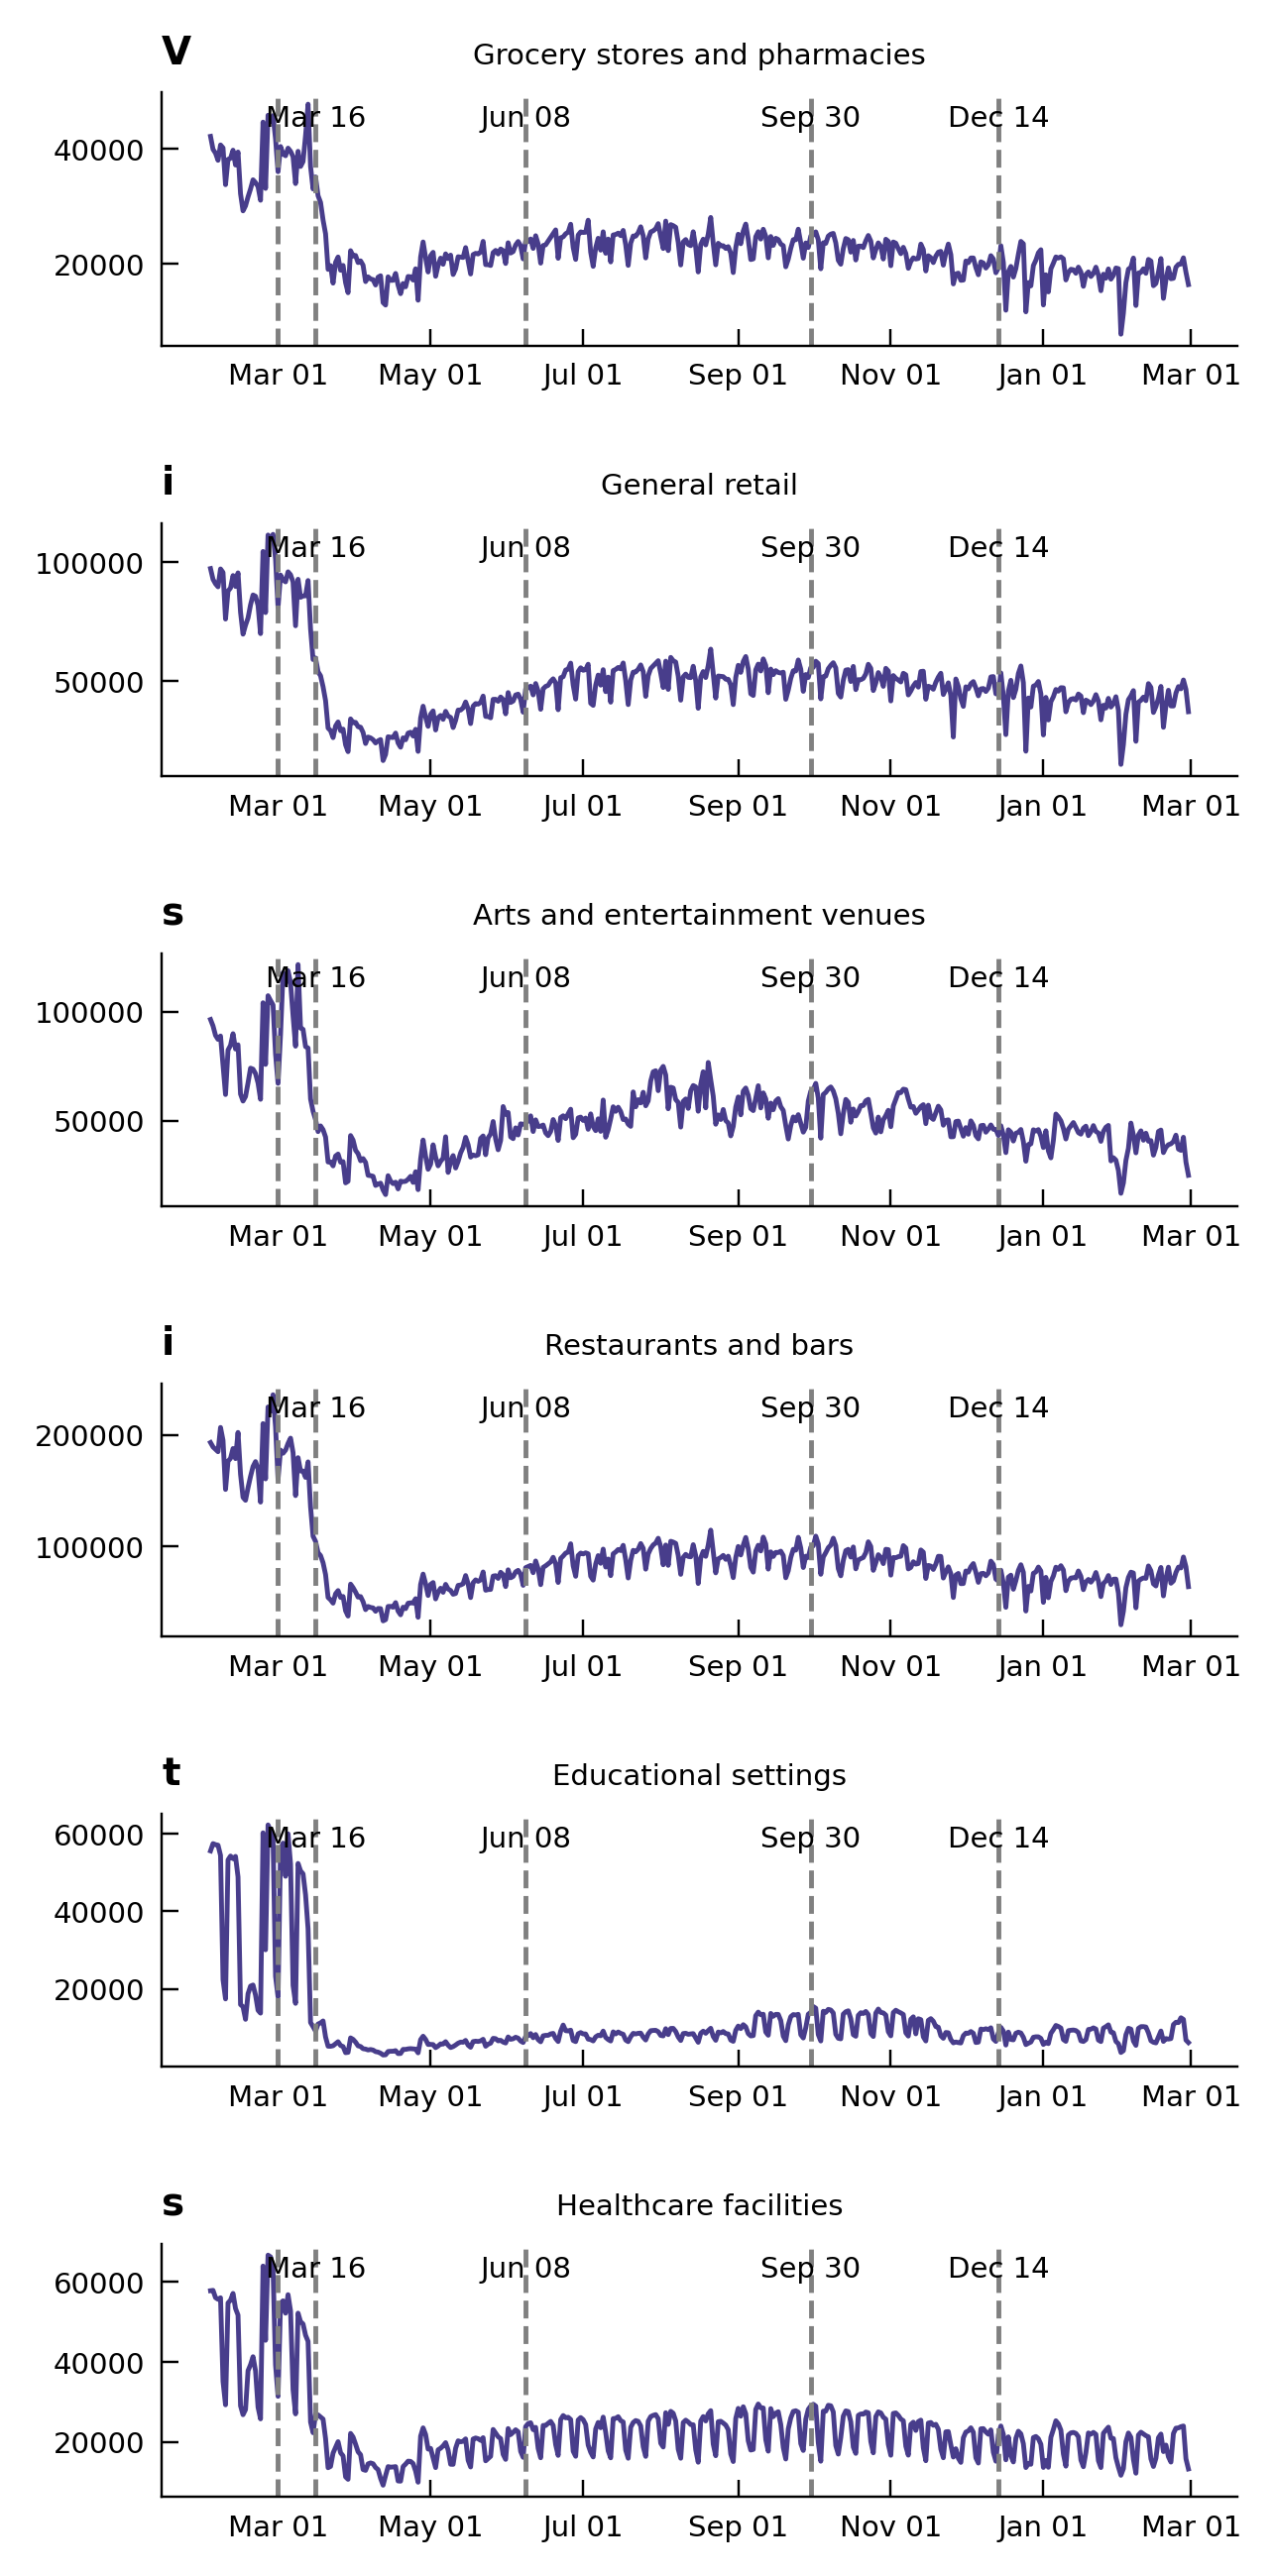

In [100]:
fig = plt.figure(figsize=(4, 9),dpi=350)  # Adjusted for 5 rows
# fig.suptitle('Start from the first week of Feb', fontsize=8, y=0.92)
gs = gridspec.GridSpec(n_categories-1, 1, height_ratios=[1]*(n_categories-1), hspace=0.7)  # 5 rows, 1 column
for c in range(6): #n_categories
    ax = plt.subplot(gs[c])
#     Ms_combined = None
#     for y in [2020, 2021]:
#         # Load and concatenate data for more months if needed
#         # Example for February, March, April (existing), extending to more months
#         months = ['01', '02'] if y == 2021 else ['02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
#         for month in months:# Extend this list with more months as needed
#             Ms = ma.h5py_to_4d_array(f'../data/{subfolder}/M_raw_{y}{month}.h5')
# #             print(y, month, Ms.shape)
#             if Ms_combined is None:
#                 Ms_combined = Ms
#             else:
#                 Ms_combined = np.concatenate((Ms_combined, Ms), axis=0)
        
        # Assuming the reshaping and summing process remains valid with additional data
    num_days = Ms_combined.shape[0] # final shape 392, 7, 177, 177
    num_weeks = int(num_days/7)
    # Ms_reshaped = Ms_combined.reshape(num_weeks, 7, n_categories, 177, 177)  # Adjust dimensions if needed
    # Ms_weekly_sums = Ms_reshaped.sum(axis=1)
    flow_out = np.sum(Ms_combined, axis=2) # final shape 392, 7, 177
    flow_all = np.sum(flow_out, axis=2) # final shape 392, 7

    data = flow_all[:, c]
    print(np.max(data),np.min(data))
    date_range = pd.date_range(start_date, periods=num_days, freq='D')
    ax.plot(date_range, data, label=f'{y}', c='darkslateblue',lw=1)
    
    for date in dates_to_mark:
        ax.axvline(date, color='gray', linestyle='--', linewidth=1)  # Mark the date with a vertical line
        if date != pd.to_datetime('2020-03-01'):
            ax.annotate(date.strftime('%b %d'), xy=(date, 0.9), xycoords=('data', 'axes fraction'),
                    ha='center', va='center', fontsize=6, rotation=0, backgroundcolor='None')
    
    ax.set_title(mp.cluster_name[c], fontsize=6)
    # ax.set_xlabel('Time from the first Monday', fontsize=6)
    ax.set_title(subtitle_text[c], fontsize=8,loc='left',fontweight='bold')
#     ax.set_ylabel('The weekly total flow out', fontsize=8)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    ax.tick_params(axis='both', which='major', labelsize=6,width=0.5,direction='in')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(0.5)  # Left spine with thinner line
    ax.spines['bottom'].set_linewidth(0.5)
#     ax.axvspan(27.5, 28.5, facecolor='gray', alpha=0.5, label='2nd March (Monday)')
# Assuming the legend in the last subplot is still desired
handles, labels = ax.get_legend_handles_labels()
# fig.legend(handles, labels, loc='best')

# plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the main 
# plt.savefig('../results/plots_maps/mobility_cate7_1to1.png',bbox_inches='tight',pad_inches=0,dpi = 350)

### Save as dataframe format including the MODZCTA for further analysis

In [12]:
df_mod_idx = pd.read_csv('../results/counts/modzcta_zip_counts.csv')
modzcta = df_mod_idx[['MODZCTA','mod_idx']]
df_mod = modzcta.sort_values(by='mod_idx').drop_duplicates() 
## this modzcta index order is the same as the mobility matrix order
df_mod = df_mod.reset_index(drop=True)

In [ ]:
Lists_all_names = []
new_data = {}
Ms_wksum_out = flow_out_wk

for c in range(n_categories):
    # c_name = mp.cluster_name[c]
    c_name = mp.cluster_name0[c]
    print(c_name)
    wksum = Ms_wksum_out[:, c, :]
    print(wksum.shape[0])
    list_names = [c_name + '_' + str(i) for i in range(wksum.shape[0])]  
    Lists_all_names.extend(list_names)
    
    # Append the new data to the dictionary with the appropriate column names
    for n_i, n in enumerate(list_names):
        new_data[n] = wksum[n_i, :]


df_new_data = pd.DataFrame(new_data)
df_mod = pd.concat([df_mod, df_new_data], axis=1)
df_mod['MODZCTA'] = df_mod['MODZCTA'].astype(str)

In [7]:
df_mod.to_csv('../data/raw_mobility/outflow_7c_wk_raw_{}.csv'.format(mobility_map_method),index=False)

### Geoplot

In [14]:
### read shapefile for geo plotting
gdf = gpd.read_file('../Data/geography_data/MODZCTA_2010.shp')
gdf['MODZCTA'] = gdf['MODZCTA'].astype(np.int64)
### include the population data
df_sed_nyc = pd.read_csv('../Data/sed_nyc_modzcta_2021.csv')
df_pop = df_sed_nyc[['MODZCTA','Population']].copy() 
# not all the zipcodes have population data extracted
df_idx = df_mod[['MODZCTA','mod_idx']].copy()
df_idx['MODZCTA'] = df_idx['MODZCTA'].astype(int)
df_pop_sorted = df_idx.merge(df_pop, on='MODZCTA', how='left')

#### **Variance plots** (not used in the MS)

In [ ]:
ms_geo  = Ms_wksum_out[6:,:,:] ### from 2020-03-16 to 2021-02-28
print(ms_geo.shape)
ms_var = np.var(ms_geo, axis=0)
ms_var.shape
pop = df_pop_sorted['Population'].values

(50, 7, 177)


(7, 177)

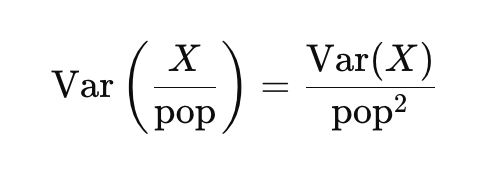

In [65]:
for c in range(6):
    c_name = mp.cluster_name[c]
    print (c_name) 
    ms_var_pop= ms_var[c,:]/(pop**2)*10_000
    print(np.nanmax(ms_var_pop), np.nanmin(ms_var_pop))
    df_pop_sorted['var_{}'.format(c)] = ms_var_pop
    gdf_merged = gdf.merge(df_pop_sorted, on='MODZCTA', how='left')

Grocery stores and pharmacies
0.20909304948486318 0.0044498961431148855
General retail
2.3841680229535687 0.06913656711200049
Arts and entertainment venues
2.0602824332273904 0.2558568920794622
Restaurants and bars
3.388604312768347 0.37821244669257265
Educational settings
0.24439623098590446 0.008251048708599428
Healthcare facilities
0.453437225744255 0.012336321961235675


Grocery stores and pharmacies
General retail
Arts and entertainment venues
Restaurants and bars
Educational settings
Healthcare facilities


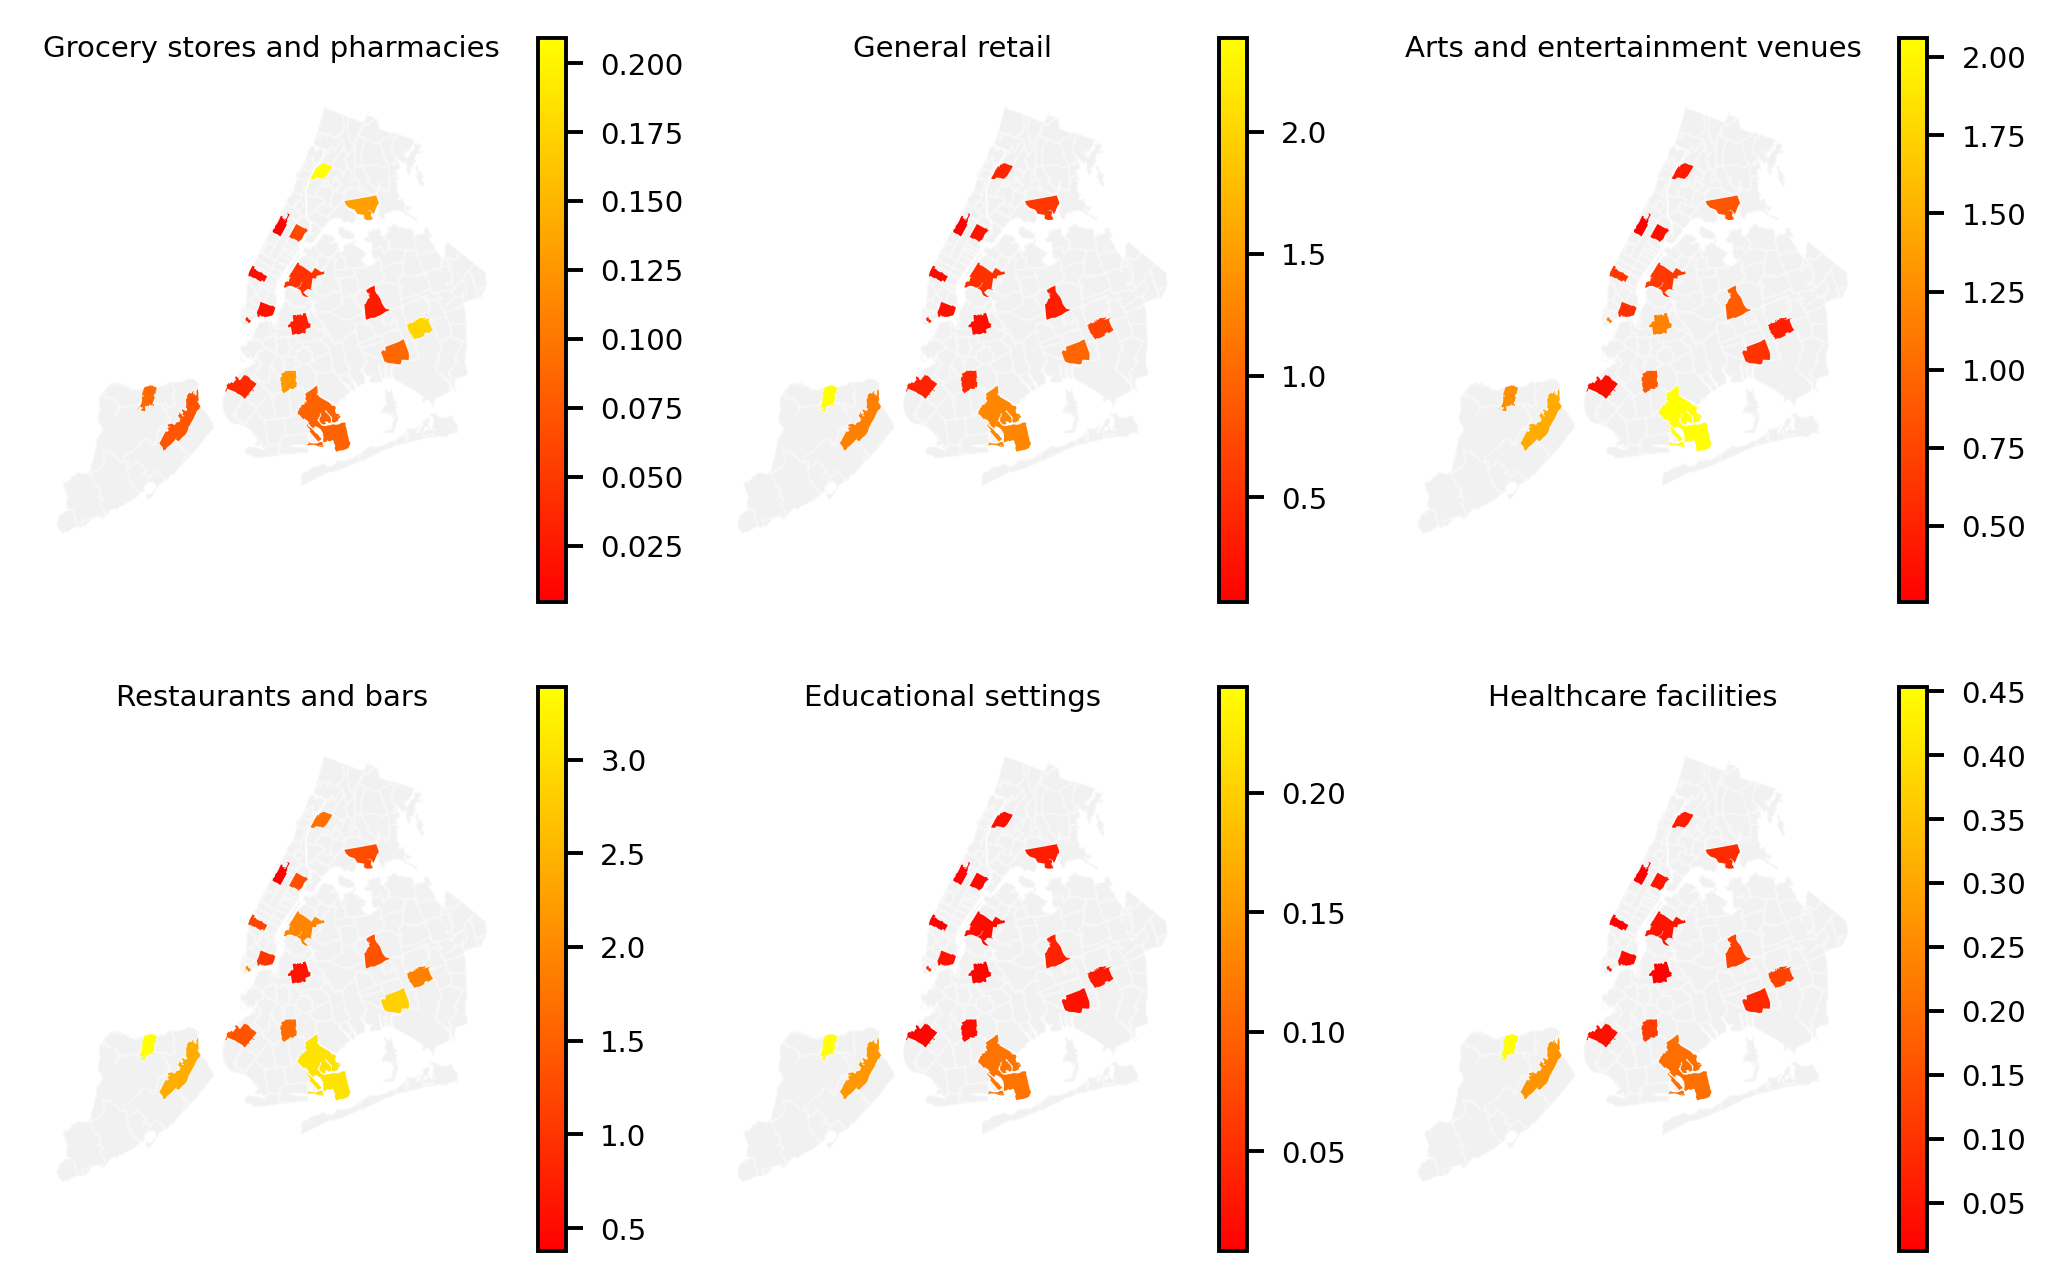

In [ ]:
dpi = 350
figsize = (7.2, 4.5)

fig = plt.figure(figsize=figsize,dpi = dpi)  
gs = gridspec.GridSpec(2, 3, height_ratios=[1,1], hspace=0.15, wspace=0.15)
axes = [fig.add_subplot(gs[i]) for i in range(6)]

for idx, ax in enumerate(axes):
    c_name = mp.cluster_name[idx]
    print (c_name)   

    gdf_merged.plot(ax=ax, color='lightgrey', edgecolor='white',linewidth=0.5,alpha=0.3)
    # norm = norm_dict_pop[c]
    cbar_plot = gdf_merged.plot(column='var_{}'.format(idx), cmap='autumn',ax=ax,legend=True)
        # Modify the colorbar font size using tick_params after it's created
    cbar = ax.get_figure().axes[-1]
    cbar.tick_params(labelsize=6) 
    # cbar.yaxis.set_major_formatter(mticker.PercentFormatter())

    ax.set_title(c_name,fontsize=6,loc='center')
    # ax.text(0.5, -0.1, subtitle_text, va='center', ha='center', transform=ax.transAxes, fontsize=10)
    ax.axis('off')
    # Save each frame to a file
    ## perpop_
filename = f'../results/plots_maps/visits_pop_var.png' #
# plt.savefig(filename, bbox_inches='tight',pad_inches=0,dpi=dpi,transparent=True)
    # plt.close()

#### **Value Change plots** (used in the MS)

In [15]:
mv_start = Ms_wksum_out[3,:,:] 
### from 2020-02-24 (Monday) to 2021-02-28 (Sunday) 53 weeks
mv_end = Ms_wksum_out[3+52,:,:]
mv_diff = ((mv_end - mv_start)/mv_start)*100
print(mv_diff.shape)
for c in range(6):
    c_name = mp.cluster_name[c]
    print (c_name) 
    print(np.nanmax(mv_diff[c]), np.nanmin(mv_diff[c]))
    df_pop_sorted['diff_{}'.format(c)] = mv_diff[c]
gdf_merged = gdf.merge(df_pop_sorted, on='MODZCTA', how='left')

(7, 177)
Grocery stores and pharmacies
-11.97862095816711 -86.2295054248003
General retail
-2.280261363220501 -85.14547069394513
Arts and entertainment venues
-6.598334959265554 -85.70459769675008
Restaurants and bars
-28.5583247238811 -84.51959614434432
Educational settings
-48.18846928294126 -95.86275605972527
Healthcare facilities
-28.45242057891577 -84.33007824127887


/var/folders/_0/2l3z2qss74scb88wvbv1szxr0000gn/T/ipykernel_63167/175783490.py:4: RuntimeWarning: invalid value encountered in divide
  mv_diff = ((mv_end - mv_start)/mv_start)*100


Grocery stores and pharmacies
General retail
Arts and entertainment venues
Restaurants and bars
Educational settings
Healthcare facilities


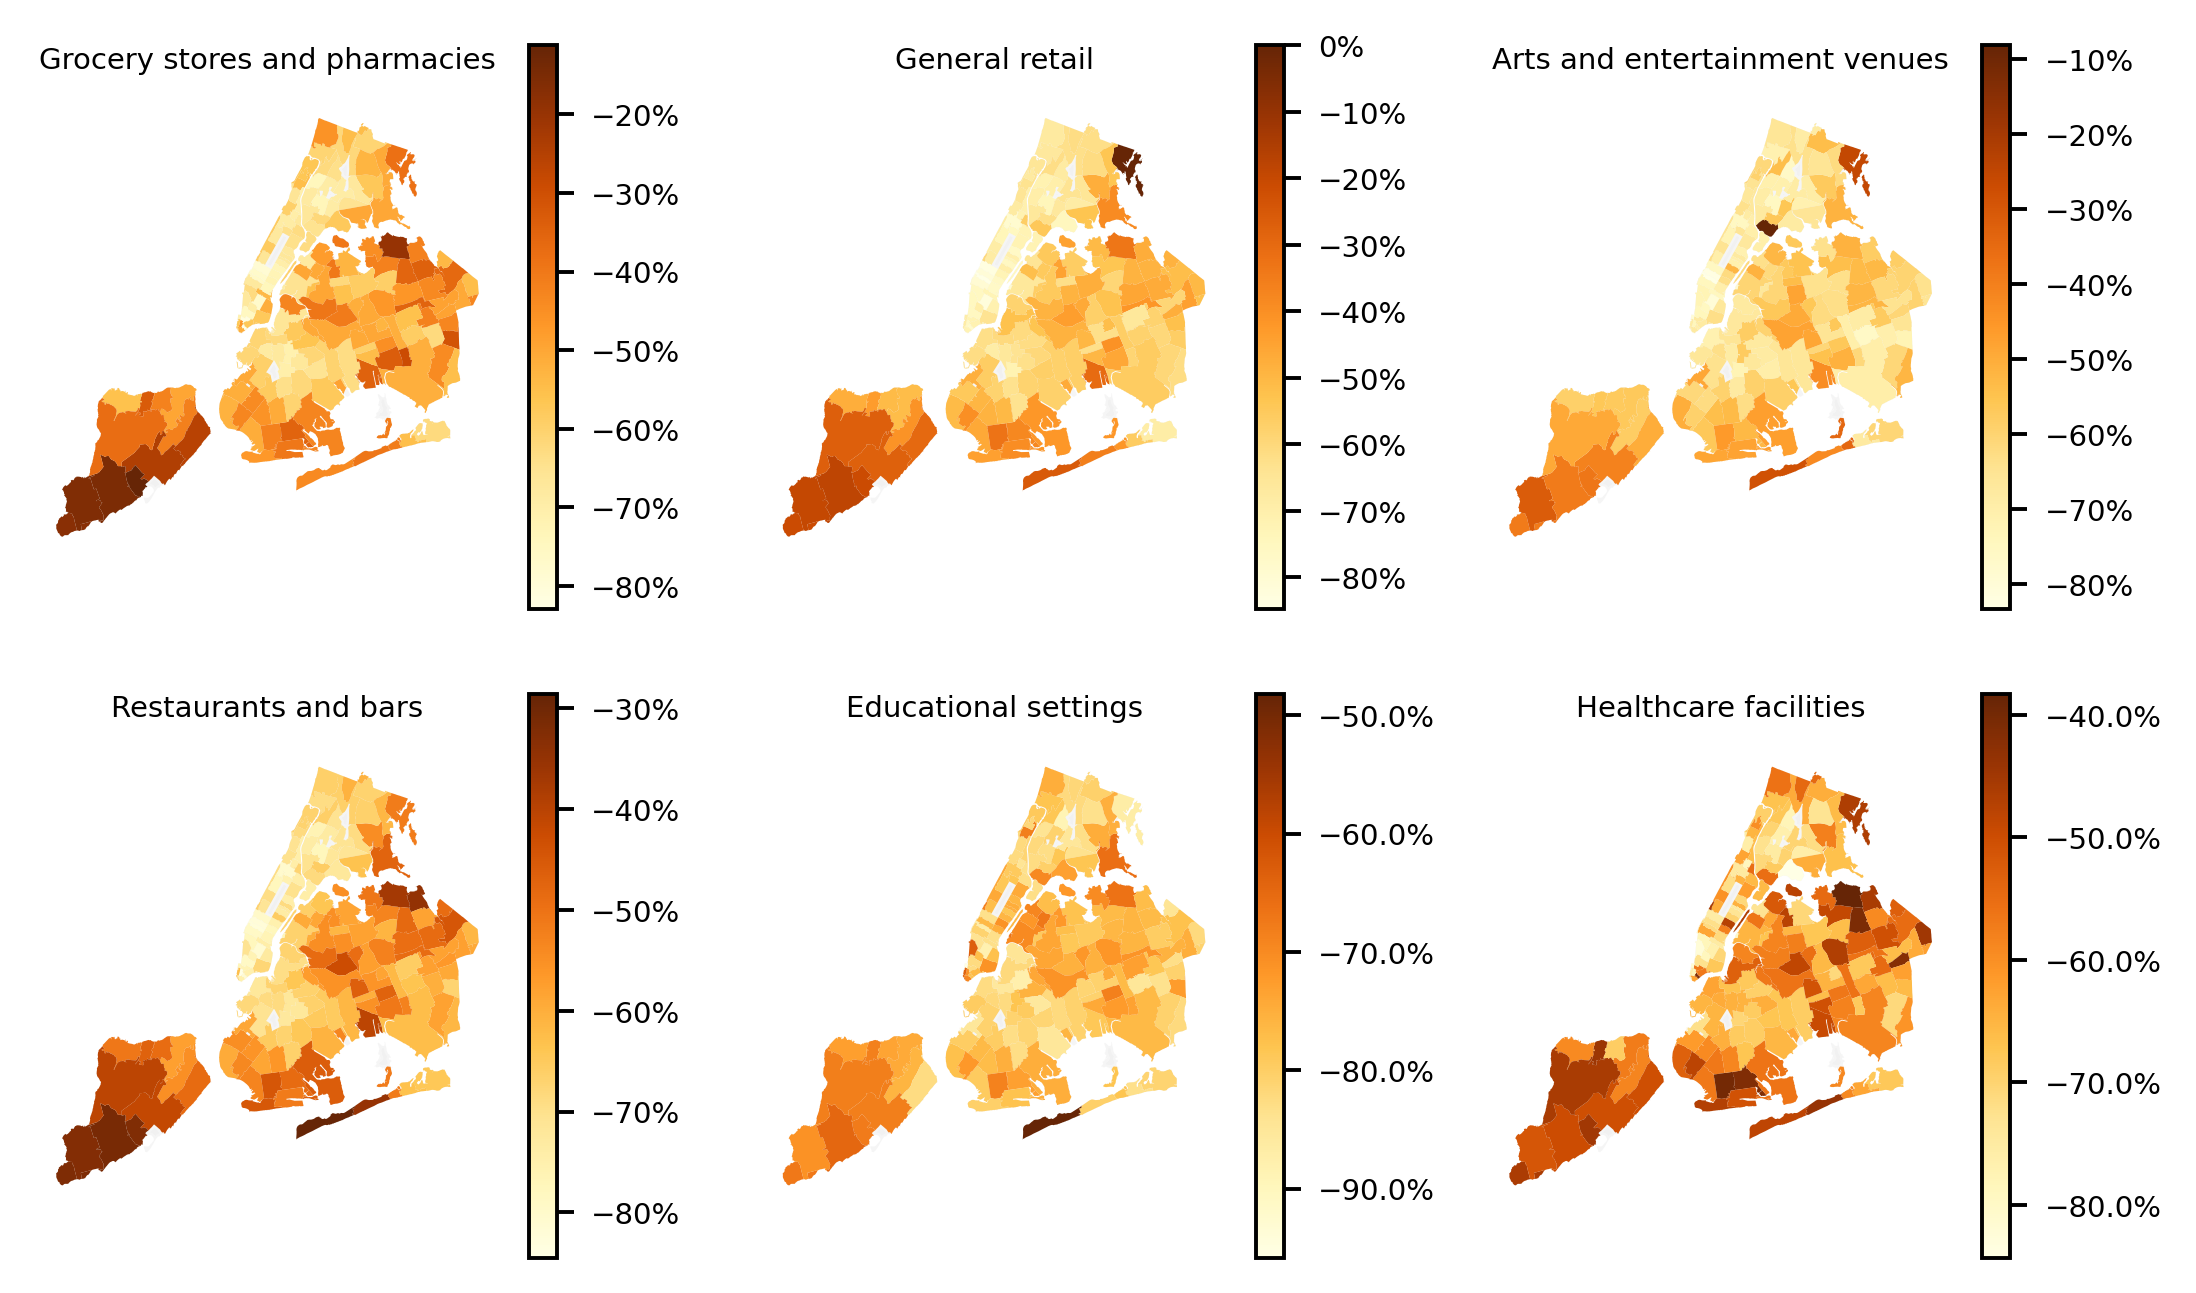

In [ ]:
dpi = 350
figsize = (7.5, 4.5)

fig = plt.figure(figsize=figsize,dpi = dpi)  
gs = gridspec.GridSpec(2, 3, height_ratios=[1,1], hspace=0.15, wspace=0.25)
axes = [fig.add_subplot(gs[i]) for i in range(6)]

for idx, ax in enumerate(axes):
    c_name = mp.cluster_name[idx]
    print (c_name)   

    gdf_merged.plot(ax=ax, color='lightgrey', edgecolor='white',linewidth=1,alpha=.3)
    # norm = norm_dict_pop[c]
    cbar_plot = gdf_merged.plot(column='diff_{}'.format(idx), cmap='YlOrBr',ax=ax,legend=True)
        # Modify the colorbar font size using tick_params after it's created
    cbar = ax.get_figure().axes[-1]
    cbar.tick_params(labelsize=6) 
    cbar.yaxis.set_major_formatter(mticker.PercentFormatter())

    ax.set_title(c_name,fontsize=6,loc='center')
    # ax.text(0.5, -0.1, subtitle_text, va='center', ha='center', transform=ax.transAxes, fontsize=10)
    ax.axis('off')
    # Save each frame to a file
    ## perpop_
filename = f'../results/plots_maps/visits_diff.png' #
# plt.savefig(filename, bbox_inches='tight',pad_inches=0,dpi=dpi,transparent=True)
    # plt.close()

### Gif plots

In [16]:
week_str_ls = []
for wk_idx in range(56):  
    week_str = str(wk_idx).zfill(2) 
    week_str_ls.append(week_str)

In [17]:
for c in range(6):
    print (mp.cluster_name[c])
    print (np.max(flow_out_wk[:,c,:]), np.min(flow_out_wk[:,c,:]))

Grocery stores and pharmacies
6673.375647617686 0.0
General retail
12096.215035883615 0.0
Arts and entertainment venues
23127.77663403366 0.0
Restaurants and bars
20680.813905623974 0.0
Educational settings
8987.926570534495 0.0
Healthcare facilities
7643.4552012460235 0.0


In [23]:
np.where(flow_out_wk[:,2,:] == np.max(flow_out_wk[:,2,:]))

(array([25]), array([94]))

In [24]:
norm_dict = {0: Normalize(vmin=400, vmax=6000), 1: Normalize(vmin=400, vmax=12000), 2: Normalize(vmin=400, vmax=10000),
             3: Normalize(vmin=400, vmax=19000), 4: Normalize(vmin=100, vmax=7000), 5: Normalize(vmin=100, vmax=7000)}

norm_dict_pop = {0: Normalize(vmin=0, vmax=6), 1: Normalize(vmin=0, vmax=13), 2: Normalize(vmin=0, vmax=13),
             3: Normalize(vmin=0, vmax=23), 4: Normalize(vmin=0, vmax=7), 5: Normalize(vmin=0, vmax=10)}

In [19]:
## sort the gdf to match the mod_idx order
sorted_gdf_merged = gdf_merged.sort_values(by='mod_idx')
sorted_gdf_merged = sorted_gdf_merged.reset_index(drop=True)
sorted_gdf_merged.dropna(subset=['mod_idx'], inplace=True)

In [26]:
dpi = 350
figsize = (12, 15)  # inches

filenames = []

for wk_idx in range(0,56):
    fig = plt.figure(figsize=figsize,dpi = dpi)  
    gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1], hspace=0.3, wspace=0.1)
    for c in range(6):
        c_name = mp.cluster_name[c]
        
        ax = plt.subplot(gs[c // 2, c % 2])
        gdf.plot(ax=ax, color='white', edgecolor='black',linewidth=0.1)
        sorted_gdf_merged['plot_wk_c'] = flow_out_wk[wk_idx,c,:]
        norm = norm_dict[c] # use for the raw visits
        # norm = norm_dict_pop[c] # use for the population 
        sorted_gdf_merged.plot(column='plot_wk_c', cmap='coolwarm',norm=norm,legend=True, ax=ax)
        # set title with the date or other relevant info
        subtitle_text = f"Visits to {c_name} in week " + week_str_ls[wk_idx]
        ax.set_title(subtitle_text)

        # ax.text(0.5, -0.1, subtitle_text, va='center', ha='center', transform=ax.transAxes, fontsize=10)
        ax.axis('off')

    # Save each frame to a file
    filename = f'../results/plots_maps/visit_gif/raw_visits/visits_{wk_idx}.png'
    # filename = f'../results/plots_maps/visit_gif/visits_perpop/perpop_visits_{wk_idx}.png'
    plt.savefig(filename, bbox_inches='tight',pad_inches=0,dpi=dpi)
    filenames.append(filename)
    plt.close()

In [27]:
from PIL import Image, ImageSequence
frames = []
for filename in filenames:
    new_frame = Image.open(filename)
    frames.append(new_frame)

# Save into a GIF file
## visits_perpop raw_visits
frames[0].save('../results/plots_maps/visit_gif/raw_visits/raw_visits.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=300,  # duration between frames in milliseconds
               loop=0)  # loop forever